In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
import random
import sklearn
from sklearn import ensemble
from itertools import chain
from typing import TextIO
import re
import seaborn as sns
from scipy import stats

In [2]:
genes_filter_1 =['RPS6', 'PRPF19', 'RPL34', 'Hsp10', 'POLR2I', 'EIF5B', 'RPL31',
       'RPS3A', 'CSE1L', 'XAB2', 'PSMD7', 'SUPT6H', 'EEF2', 'RPS11',
       'SNRPD2', 'RPL37', 'SF3B3', 'DDX51', 'RPL7', 'RPS9', 'KARS',
       'SF3A1', 'RPL32', 'PSMB2', 'RPS7', 'EIF4A3', 'U2AF1', 'PSMA1',
       'PHB', 'POLR2D', 'RPSA', 'RPL23A', 'NUP93', 'AQR', 'RPA2',
       'SUPT5H', 'RPL6', 'RPS13', 'SF3B2', 'RPS27A', 'PRPF31', 'COPZ1',
       'RPS4X', 'PSMD1', 'RPS14', 'NUP98', 'USP39', 'CDC5L', 'RPL5',
       'PHB2', 'RPS15A', 'RPS3', 'ARCN1', 'COPS6']

base_positions = {
    'A': 0,
    'T': 1,
    'C': 2,
    'G': 3,
    0: 'A',
    1: 'T',
    2: 'C',
    3: 'G',
}

In [3]:
def normalize(a: np.ndarray):
    """
    :param a: numpy array of size N x D, where N is number of examples, D is number of features
    :return: a, normalized so that all feature columns are now between 0 and 1
    """
    a_normed, norms = sklearn.preprocessing.normalize(a, norm='max', axis=0, return_norm=True)
    print("Norms:", norms)
    return a_normed

def one_hot_encode_sequence(seq, pad_to_len=-1):
    output_len = len(seq)
    if pad_to_len > 0:
        assert pad_to_len >= output_len
        output_len = pad_to_len

    encoded_seq = np.zeros((output_len, 4), dtype=np.float32)
    for i, base in enumerate(seq):
        encoded_seq[i][base_positions[base]] = 1
    return encoded_seq

In [6]:
# read full dataset features
dataframe = pd.read_csv('../data/integrated_guide_feature_filtered_f24_mismatch3_all_features.csv')
num_examples = len(dataframe['gene'].values)

#seq features
encoded_guides = [one_hot_encode_sequence(guide).flatten() for guide in dataframe['guide'].values]

#all secondary features
other_single_value_inputs = np.empty((21, num_examples))
other_single_value_inputs[0, :] = dataframe['linearfold_vals'].values
other_single_value_inputs[1, :] = dataframe['is_5UTR'].values
other_single_value_inputs[2, :] = dataframe['is_CDS'].values
other_single_value_inputs[3, :] = dataframe['is_3UTR'].values
other_single_value_inputs[4, :] = dataframe['refseq_target_transcript_percent'].values
other_single_value_inputs[5, :] = dataframe['target unfold energy']
other_single_value_inputs[6, :] = dataframe['UTR5_position'].values
other_single_value_inputs[7, :] = dataframe['CDS_position'].values
other_single_value_inputs[8, :] = dataframe['UTR3_position'].values
other_single_value_inputs[9, :] = dataframe['linearfold_dr_flag'].values
other_single_value_inputs[10, :] = dataframe['GC_content'].values
  # RNAseq datasets
other_single_value_inputs[11, :] = dataframe['RNAseq2_relative'].values
other_single_value_inputs[12, :] = dataframe['RNAseq3_relative'].values
other_single_value_inputs[13, :] = dataframe['RNAseq7_relative'].values
other_single_value_inputs[14, :] = dataframe['RNAseq8_relative'].values

#GC content in the window 17-23 and out of the window
gc_content_win = []
gc_content_out = []
for guide in dataframe['guide'].values:
    gc_whole = (guide.upper()).count('G') + (guide.upper()).count('C')
    gc_num = (guide[16:23].upper()).count('G') + (guide[16:23].upper()).count('C')
    gc_content_win.append(gc_num/7)
    gc_content_out.append((gc_whole-gc_num)/23)
    
other_single_value_inputs[15, :] = gc_content_win
other_single_value_inputs[16, :] = gc_content_out
dataframe['GC_content_mid'] = gc_content_win

# mid window features
other_single_value_inputs[17, :] = dataframe['linearfold_vals_7win'].values
other_single_value_inputs[18, :] = dataframe['linearfold_vals_23win'].values
other_single_value_inputs[19, :] = dataframe['target unfold energy_7win'].values
other_single_value_inputs[20, :] = dataframe['target unfold energy_23win'].values

all_cols = np.concatenate((encoded_guides, normalize(other_single_value_inputs.T)),axis=1)

#feature labels
nuc_labels = []
for p in range(30):
    for bi in range(4):
        nuc_label = 'pos'+str(p+1)+'_'+ base_positions[bi]
        nuc_labels.append(nuc_label)
        
feature_list_all=['guide free energy',"is 5'UTR",'is CDS',"is 3'UTR",'target transcript percent','target unfolding energy',
"5'UTR position",'CDS position',"3'UTR position",'direct repeat disruption','GC content',
                  'RNAseq dataset2 read abundance','RNAseq dataset3 read abundance','RNAseq dataset7 read abundance','RNAseq dataset8 read abundance',
                  'GC content in seed region','GC content out of seed region','guide unfolding energy in seed region','guide unfolding energy out of seed region','target unfolding energy in seed region','target unfolding energy out of seed region']
feature_names = nuc_labels + feature_list_all
df_select = pd.DataFrame(data=all_cols,
                         columns=feature_names)
df_select['output'] = dataframe['binary_relative_ratio_075f'].values
df_select['relative ratio'] = dataframe['relative_ratio'].values

Norms: [11.93        1.          1.          1.          1.         15.67
  1.          0.99981488  0.99470448  1.          0.96666667  1.
  1.          1.          1.          1.          1.         11.29
 11.93       13.66       15.67      ]


In [7]:
#whole dataset correlation with good guide label
df_pearson = df_select.corrwith(df_select['output'], method='pearson')
seq_corr = df_pearson.to_numpy()[0:120]
#df_pearson.to_csv('seq_feature_correlation_pearson2.csv')
df_spearman = df_select.corrwith(df_select['output'], method='spearman')
df_com = pd.concat([df_pearson, df_spearman],axis=1)
df_com.to_csv('../seq_feature_correlation_goodguide_label_ps.csv')

Text(0.5, 1.0, 'Pearson correlation: feature correlation')

<Figure size 432x288 with 0 Axes>

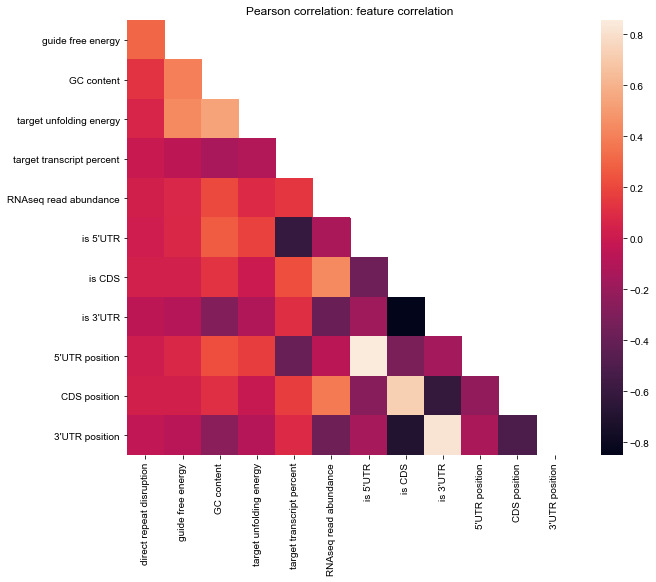

In [34]:
#feature pairwise pearson and spearman correlation
df_select.rename(columns={"RNAseq dataset7 read abundance": "RNAseq read abundance"},inplace=True)
#dataframe['relative_ratio'] = 1- dataframe['relative_ratio']
#dataframe_select = dataframe[['relative_ratio','binary_relative_ratio_075f','bad guide_90th_pct','is_5UTR','is_CDS','is_3UTR','UTR5_position','CDS_position','UTR3_position','ensembl_target_transcript_percent','refseq_target_transcript_percent','linearfold_vals','linearfold_dr_flag','target unfold energy','GC_content',
#                             'GC_content_mid','linearfold_vals_7win','target unfold energy_7win']]
dataframe_select = df_select[['direct repeat disruption','guide free energy','GC content','target unfolding energy','target transcript percent','RNAseq read abundance',
                             "is 5'UTR",'is CDS',"is 3'UTR","5'UTR position",'CDS position',"3'UTR position"]]

plt.clf()
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

plt.figure(figsize=(10,8))
corrMatrix = dataframe_select.corr()
#corrMatrix.to_csv('feature_correlation_pearson.csv')
mask = np.zeros_like(corrMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# using the upper triangle matrix as mask 
hp =sns.heatmap(corrMatrix[1:], mask=mask[1:])
plt.title('Pearson correlation: feature correlation')
#df_pearson = corrMatrix[['relative_ratio','binary_relative_ratio_075f','bad guide_90th_pct']].rename(columns={'relative_ratio':'relative_ratio_pearson', 'binary_relative_ratio_075f': 'binary_relative_ratio_pearson','bad guide_bottom20%':'bad guide_pearson'})

<Figure size 432x288 with 0 Axes>

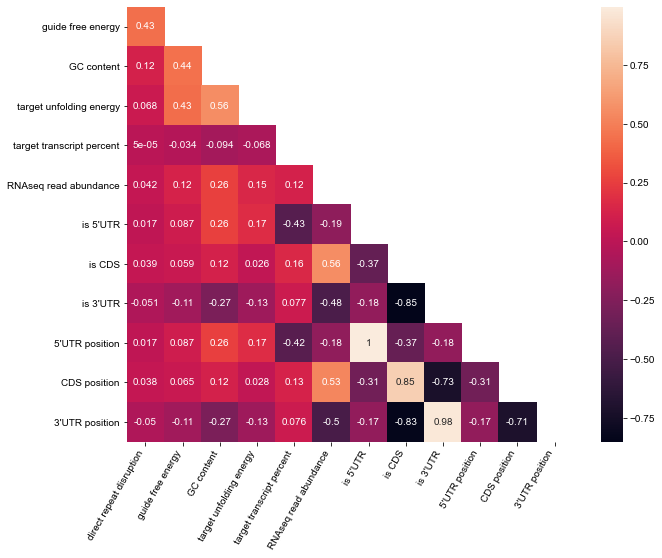

In [35]:
corrMatrix2 = dataframe_select.corr(method='spearman')
# Getting the Upper Triangle of the co-relation matrix
#matrix = np.triu(corrMatrix2)

#corrMatrix2.to_csv('feature_correlation_spearman.csv')
#df_spearman = corrMatrix2[['relative_ratio','binary_relative_ratio_075f','bad guide_90th_pct']].rename(columns={'relative_ratio':'relative_ratio_spearman', 'binary_relative_ratio_075f': 'binary_relative_ratio_spearman','bad guide_90th_pct':'bad guide_spearman'})
plt.clf()
plt.figure(figsize=(10,8))
mask = np.zeros_like(corrMatrix2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# using the upper triangle matrix as mask 
hp =sns.heatmap(corrMatrix2[1:], annot=True,mask=mask[1:])
#hp = sns.heatmap(corrMatrix2, annot=True, mask=matrix)

#hp.set_title('spearman correlation: feature correlation')
hp.set_xticklabels(hp.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.savefig(fname='../a_figures/feature_correlation_spearman.svg')

In [15]:
df_com = pd.concat([df_pearson, df_spearman],axis=1)
df_com.to_csv('feature_correlation.csv')

<Figure size 432x288 with 0 Axes>

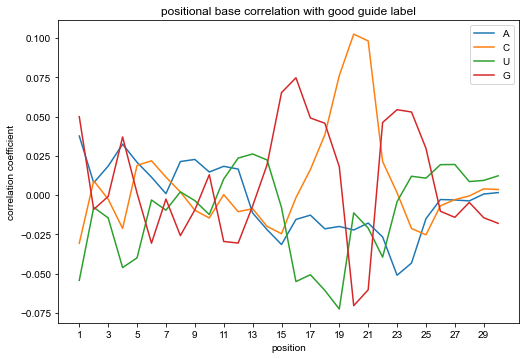

In [19]:
# sequence correlation for each nucletide
a_pos =[]
t_pos =[]
c_pos =[]
g_pos =[]
for ii in range(30):
    ai = ii*4+ base_positions['A']
    a_pos.append(seq_corr[ai])
    ti = ii*4+ base_positions['T']
    t_pos.append(seq_corr[ti])
    ci = ii*4+ base_positions['C']
    c_pos.append(seq_corr[ci])
    gi = ii*4+ base_positions['G']
    g_pos.append(seq_corr[gi])

plt.clf()
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0.1,0.2,0.8,0.7])
major_ticks = np.arange(1, 31, 2)
ax.set_xticks(major_ticks)
# And a corresponding grid
#ax.grid(which='major')

plt.plot(np.arange(1,31),a_pos,label='A')
plt.plot(np.arange(1,31),c_pos,label='C')
plt.plot(np.arange(1,31),t_pos,label='U')
plt.plot(np.arange(1,31),g_pos,label='G')
#plt.xlim(1,30)
plt.legend()
plt.xlabel('position')
plt.ylabel('correlation coefficient')
plt.title('positional base correlation with good guide label')
plt.savefig(fname='../a_figures/correlation_one_pos_kfold.svg')

## good guide percent in feature bins

In [10]:
features = ['linearfold_vals','linearfold_dr_flag','GC_content','target unfold energy','refseq_target_transcript_percent','RNAseq7_relative',
            'is_5UTR','is_CDS','is_3UTR','UTR5_position','CDS_position','UTR3_position',
            'GC_content_mid','linearfold_vals_7win','target unfold energy_7win']
feature_name = ['guide free energy','direct repeat disruption','GC content','target unfolding energy','target isoform percent','RNAseq read abundance',
                "is 5' UTR",'is CDS',"is 3' UTR","5' UTR position",'CDS position',"3' UTR position",
                 'GC content in seed region','guide unfolding energy in seed region','target unfolding energy in seed region']

<ipython-input-11-44ea83a6b3d8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonzero['feature_bins'] = pd.cut(df_nonzero[features[i]],
<ipython-input-11-44ea83a6b3d8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonzero['feature_bins'] = pd.cut(df_nonzero[features[i]],
<ipython-input-11-44ea83a6b3d8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

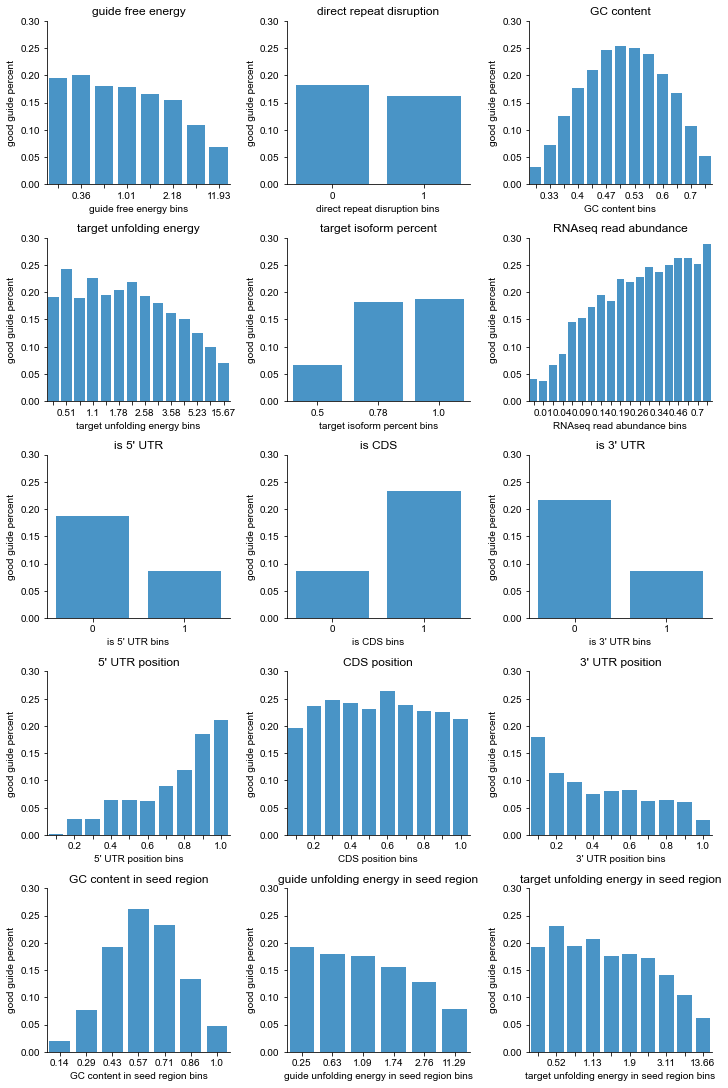

In [11]:
#fig, ax = plt.subplots(4,3,figsize=(8,12),constrained_layout=True)
fig, ax = plt.subplots(5,3,figsize=(10,15),constrained_layout=True)
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
sns.despine(left=False, bottom=False)

for i in range(len(features)):
    px = int((i-i%3)/3)
    py = int(i%3)
    if features[i] in ['is_5UTR','is_CDS','is_3UTR','linearfold_dr_flag']:
        #sns.barplot(x=features[i], y='binary_relative_ratio_075f', data=dataframe,ci=None,
         #         palette="Blues",ax=ax[px,py])
        sns.barplot(x=features[i], y='binary_relative_ratio_075f', data=dataframe,ci=None,
                  color="#3498db",ax=ax[px,py])
        #sns.barplot(x=features[i], y='binary_relative_ratio_075f', data=dataframe,ci=None,
        #          palette="crest",ax=ax[px,py])
        #fm = dataframe.groupby(features[i])['binary_relative_ratio_075f'].agg('mean')
        #fm.plot(ax=ax[px,py])
    elif features[i] in ['UTR5_position','CDS_position','UTR3_position']: #filter 0
        df_nonzero = dataframe[dataframe[features[i]]!=0]
        bin_labels = [i/10 for i in range(1,11)]
        df_nonzero['feature_bins'] = pd.cut(df_nonzero[features[i]],
                                  bins=10,
                                  labels=bin_labels)
        sns.barplot(x='feature_bins', y='binary_relative_ratio_075f', data=df_nonzero,ci=None,
                  color="#3498db",ax=ax[px,py])
        #ax[px,py].tick_params(bottom=False)
        for label in ax[px,py].xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
    else:
        #divide to 20 bins based on feature input
        #bin_labels = [i for i in range(1,21)]
        #dataframe['feature_bins'] = pd.cut(dataframe[features[i]],
        #                          bins=20,labels=bin_labels)
        dataframe['feature_bins'] = pd.qcut(dataframe[features[i]],
                              q=20,
                              duplicates='drop')
        dataframe['feature_bins'] = dataframe['feature_bins'].map(lambda x : round(x.right,2))
        sns.barplot(x='feature_bins', y='binary_relative_ratio_075f', data=dataframe,ci=None,
                  color="#3498db",ax=ax[px,py])        
        if len(set(dataframe['feature_bins'].values))>7:
            for label in ax[px,py].xaxis.get_ticklabels()[::2]:
                label.set_visible(False)

    #df_class[features[i]].hist(grid=False, alpha = 0.4,bins=50,density = True,ax=ax[px,py],legend = True)
    ax[px,py].set_ylim((0,0.3))
    #ax[px,py].set(xticklabels=[])
    #ax[px,py].set_xticklabels(ax[px,py].get_xticklabels(), rotation=60, horizontalalignment='right')
    
    ax[px,py].set_title(feature_name[i])
    ax[px,py].set_xlabel(feature_name[i]+' bins')
    ax[px,py].set_ylabel('good guide percent')
    #ax[px,py].legend()
plt.savefig('../a_figures/feature_distribution_bins_goodg_pct.svg', format="svg")

## feature distribution for guide efficiency bins

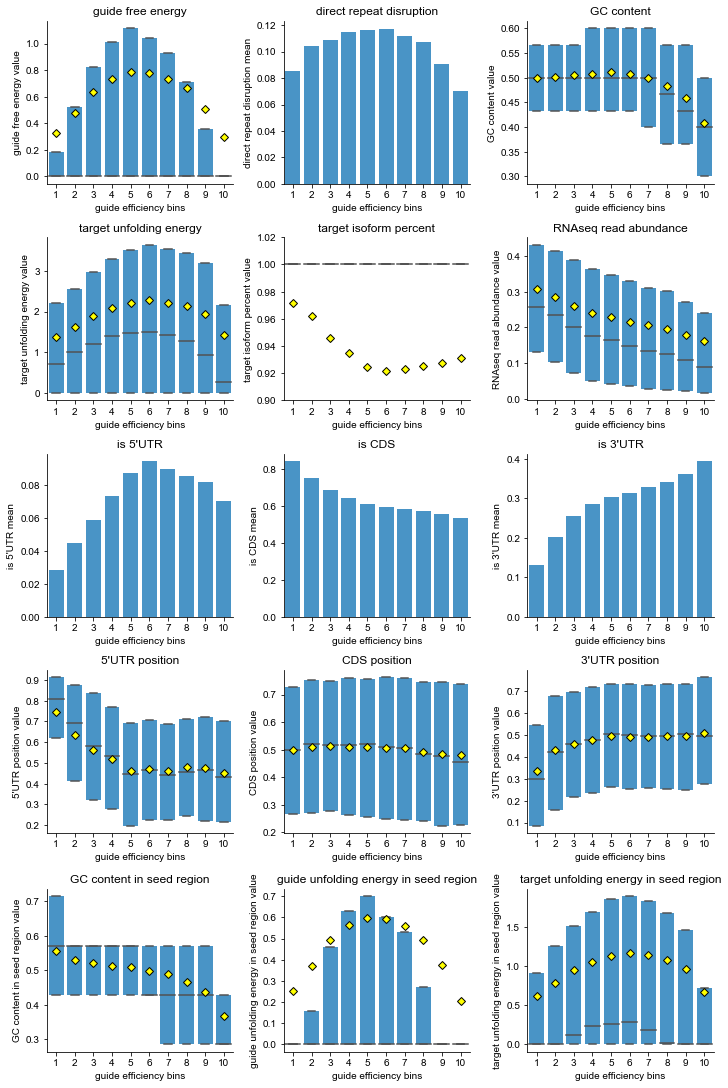

In [40]:
#bar plot and box plot, guides binned by relative ratio

plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

PROPS = {
    'boxprops':{'facecolor':'grey', 'edgecolor':'black'},
    'medianprops':{'color':'green'},
    'whiskerprops':{'color':'blue'},
    'capprops':{'color':'black'}
}

#fig, ax = plt.subplots(4,3,figsize=(9,12),constrained_layout=True)
fig, ax = plt.subplots(5,3,figsize=(10,15),constrained_layout=True)
sns.despine(left=False, bottom=False,right=True,top=True)
for i in range(len(features)):
    px = int((i-i%3)/3)
    py = int(i%3)
    if features[i] in ['is_5UTR','is_CDS','is_3UTR','linearfold_dr_flag']: #flag features, bar plot
        sns.barplot(x="bins", y=features[i], data=dataframe,ci=None,
                  color="#3498db",ax=ax[px,py])
    elif features[i] in ['UTR5_position','CDS_position','UTR3_position']: #filter 0
        df_nonzero = dataframe[dataframe[features[i]]!=0]
        #df_nonzero.boxplot(column=features[i], by='bins', ax=ax[px,py], grid=False,showfliers=False)
        #sns.boxplot(x="bins", y=features[i], data=df_nonzero,ax=ax[px,py],showfliers=False,palette="ch:s=.25,rot=-.25",meanline=True)
        sns.boxplot(x="bins", y=features[i], data=df_nonzero,ax=ax[px,py],showfliers=False,whis=0,color="#3498db",
                    boxprops={'edgecolor':'white','linewidth':0},
                    showmeans=True,meanprops={"marker":"D","markerfacecolor":"yellow", "markeredgecolor":"black"})
        #sns.color_palette("light:#5A9", as_cmap=True)
        #sns.boxplot(x="bins", y=features[i], data=df_nonzero,ax=ax[px,py],showfliers=False,**PROPS)
    else:
        #dataframe.boxplot(column=features[i], by='bins', ax=ax[px,py], grid=False,showfliers=False) 
        #sns.boxplot(x="bins", y=features[i], data=dataframe,ax=ax[px,py],showfliers=False,palette="ch:s=.25,rot=-.25",meanline=True)
        sns.boxplot(x="bins", y=features[i], data=dataframe,ax=ax[px,py],showfliers=False,whis=0,color="#3498db",
                    boxprops={'edgecolor':'white','linewidth':0},
                    #medianprops=dict(color='black'),
                    showmeans=True,meanprops={"marker":"D","markerfacecolor":"yellow", "markeredgecolor":"black"})
        #sns.color_palette("light:#5A9", as_cmap=True)
        #sns.boxplot(x="bins", y=features[i], data=dataframe,ax=ax[px,py],showfliers=False,**PROPS)
    ax[px,py].set_title(feature_name[i])
    if feature_name[i] == 'target isoform percent':
        ax[px,py].set_ylim(0.9,1.02)
    ax[px,py].set_xlabel('guide efficiency bins')
    if features[i] in ['is_5UTR','is_CDS','is_3UTR','linearfold_dr_flag']:
        ax[px,py].set_ylabel((feature_name[i]+' mean'))
    else:  
        ax[px,py].set_ylabel((feature_name[i]+' value'))
    
plt.savefig('../a_figures/feature_distribution_bins_boxplot.svg', format="svg")

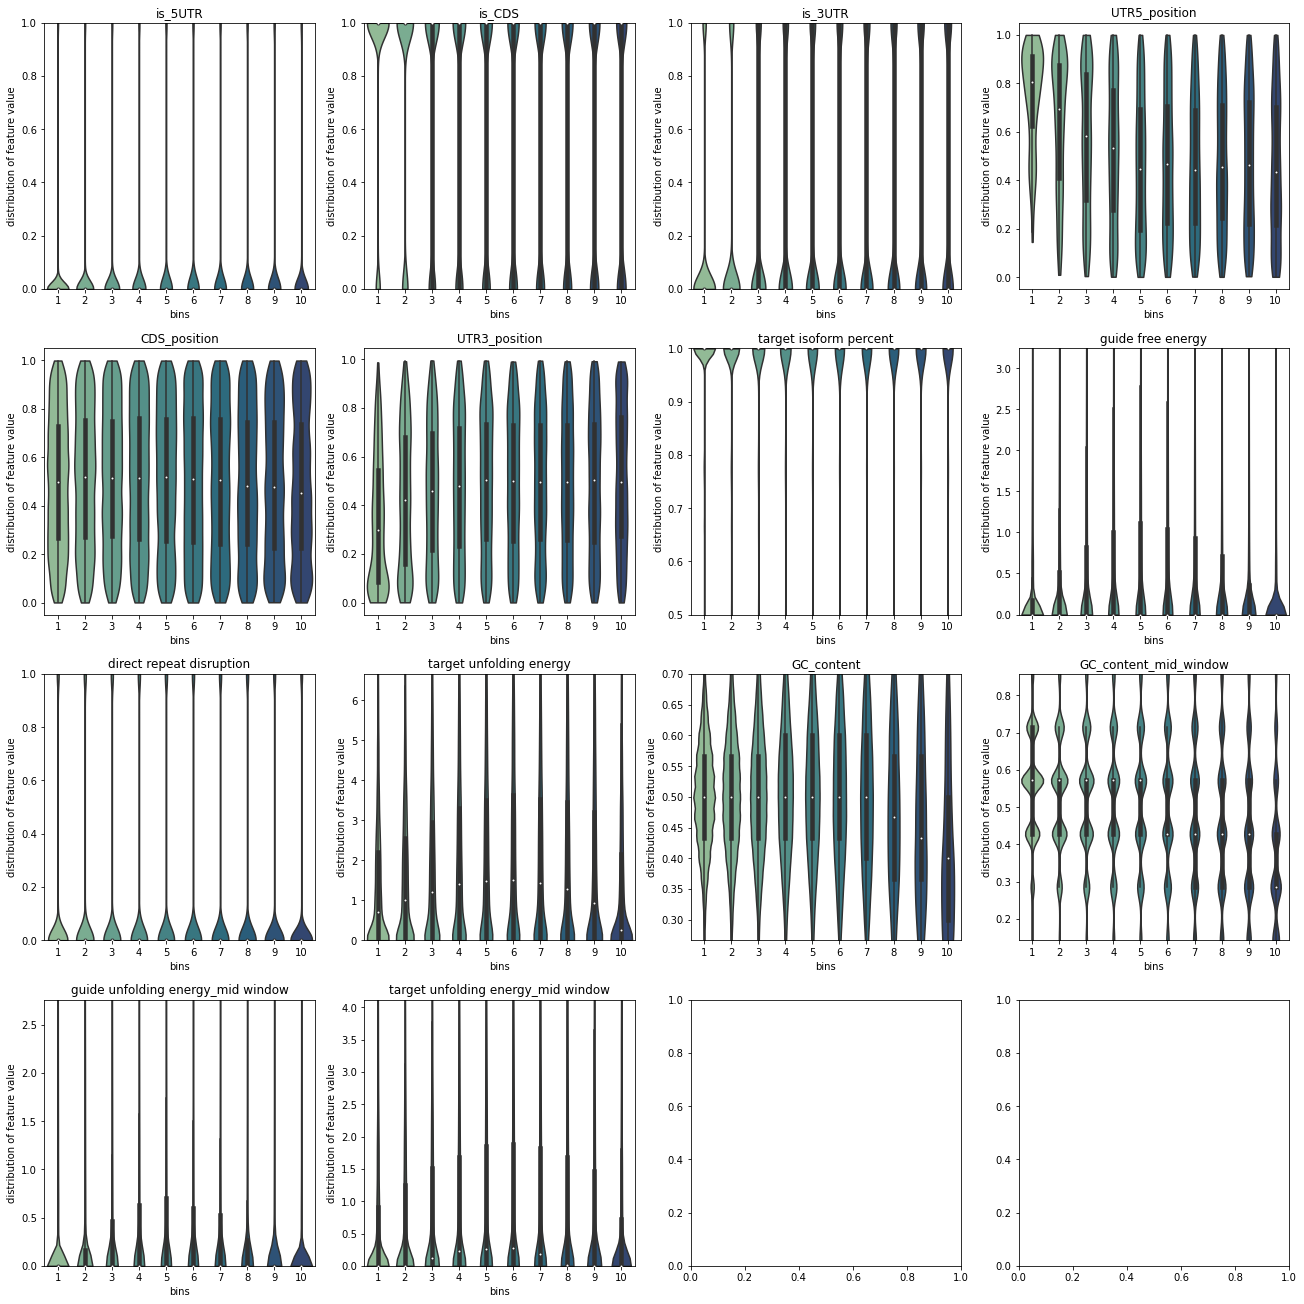

In [21]:
#violin plot
fig, ax = plt.subplots(4,4,figsize=(18,18),constrained_layout=True)
for i in range(len(features)):
    px = int((i-i%4)/4)
    py = int(i%4)
    if features[i] in ['UTR5_position','CDS_position','UTR3_position']: #filter 0
        df_filter = dataframe[dataframe[features[i]]!= 0]
        sns.violinplot(x="bins", y=features[i],data=df_filter, cut=0,palette="crest",ax=ax[px,py])
        #ax[px,py].set_ylim(np.percentile(dataframe[features[i]].values, 5),np.percentile(dataframe[features[i]].values, 95))
    else:
        sns.violinplot(x="bins", y=features[i],data=dataframe, cut=0,palette="crest",ax=ax[px,py])
        ax[px,py].set_ylim(np.percentile(dataframe[features[i]].values, 5),np.percentile(dataframe[features[i]].values, 95))
    ax[px,py].set_title(feature_name[i])
    ax[px,py].set_xlabel('bins')
    ax[px,py].set_ylabel('distribution of feature value')
    #ax[px,py].set_ylim(np.percentile(dataframe[features[i]].values, 5),np.percentile(dataframe[features[i]].values, 95))
    
#plt.savefig('a_figures/feature_distribution_bins.svg', format="svg")

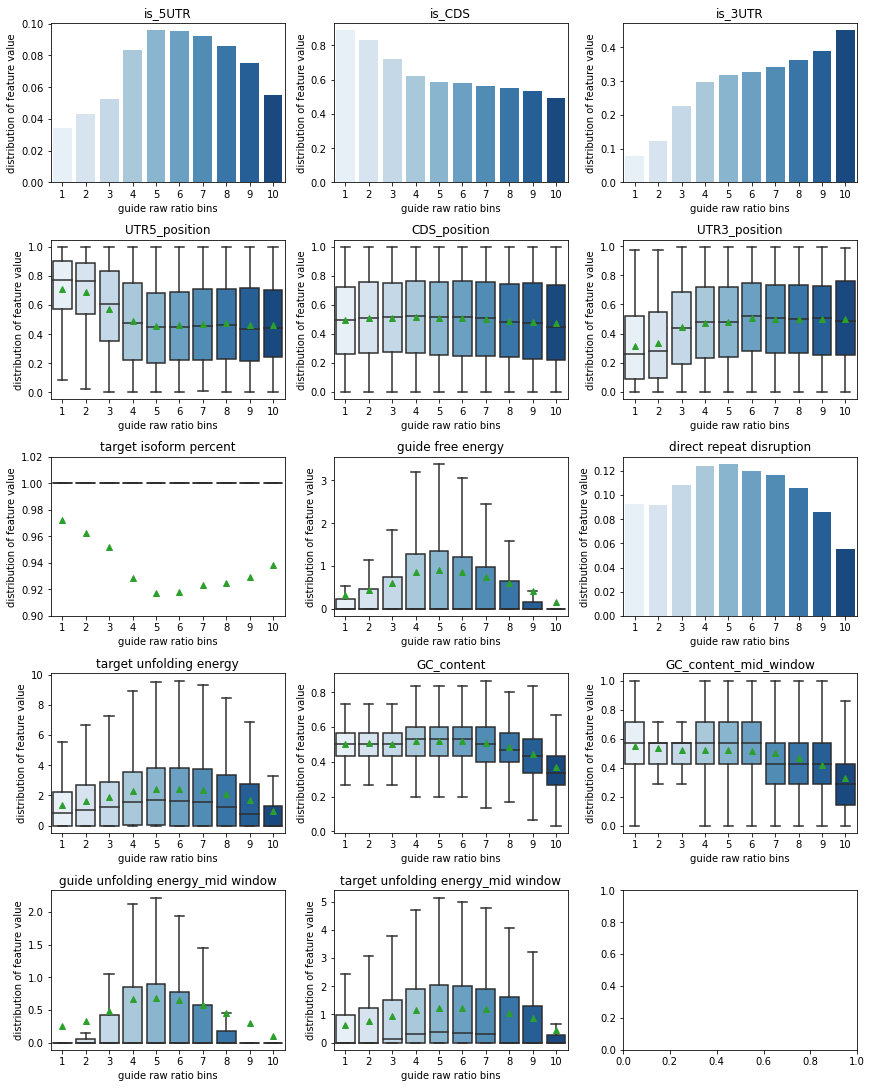

In [16]:
# guides binned by raw ratio
bin_labels = [i for i in range(1,11)]
dataframe['ratio bins'] = pd.qcut(dataframe['raw ratio'],
                              q=10,
                              labels=bin_labels)

fig, ax = plt.subplots(5,3,figsize=(12,15),constrained_layout=True)
for i in range(len(features)):
    px = int((i-i%3)/3)
    py = int(i%3)
    if features[i] in ['is_5UTR','is_CDS','is_3UTR','linearfold_dr_flag']: #flag features, bar plot
        sns.barplot(x="ratio bins", y=features[i], data=dataframe,ci=None,
                  palette="Blues",ax=ax[px,py])
    elif features[i] in ['UTR5_position','CDS_position','UTR3_position']: #filter 0
        df_nonzero = dataframe[dataframe[features[i]]!=0]
        sns.boxplot(x="ratio bins", y=features[i], data=df_nonzero,ax=ax[px,py],showfliers=False,palette="Blues",showmeans=True)
    else: 
        sns.boxplot(x="ratio bins", y=features[i], data=dataframe,ax=ax[px,py],showfliers=False,palette="Blues",showmeans=True)
    ax[px,py].set_title(feature_name[i])
    if feature_name[i] == 'target isoform percent':
        ax[px,py].set_ylim(0.9,1.02)
    ax[px,py].set_xlabel('guide raw ratio bins')
    ax[px,py].set_ylabel('distribution of feature value')

## feature interaction

<Figure size 432x288 with 0 Axes>

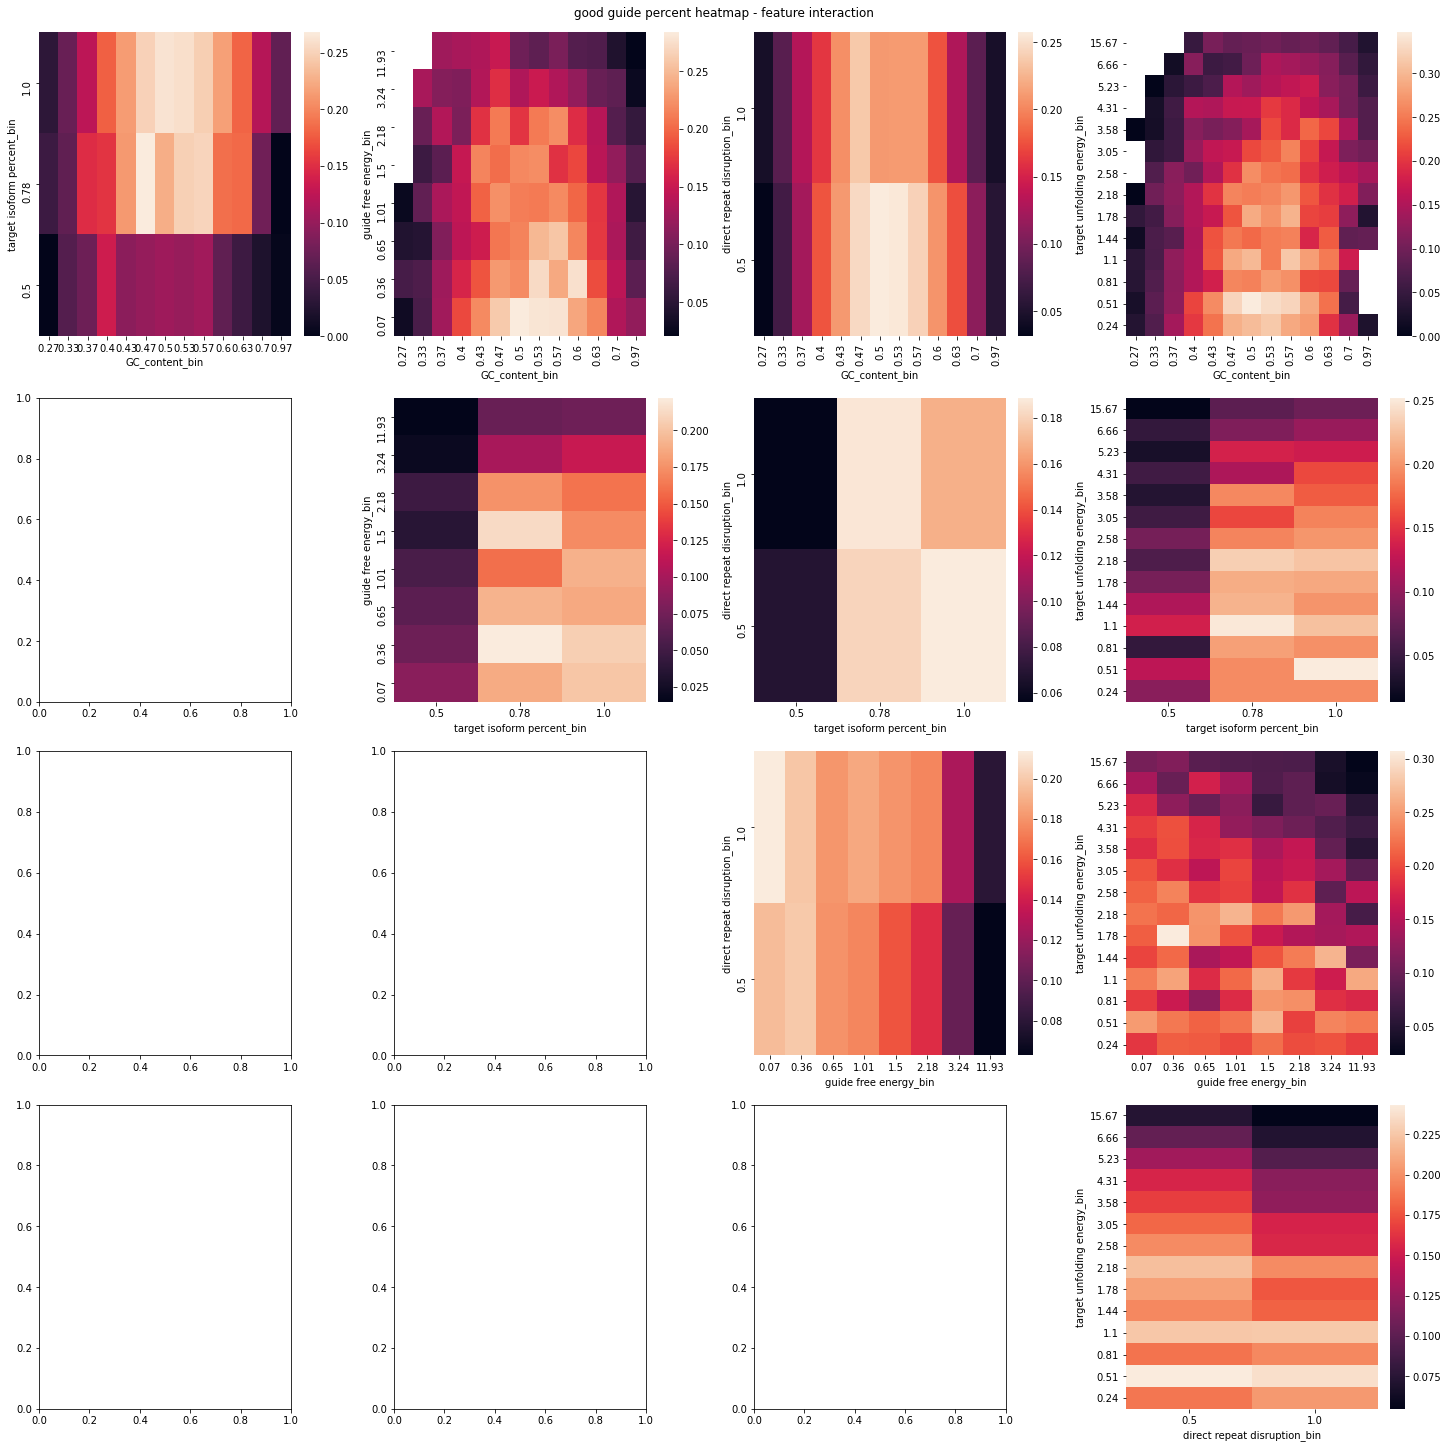

In [6]:
features = ['is_5UTR','is_CDS','is_3UTR','UTR5_position','CDS_position','UTR3_position','GC_content','refseq_target_transcript_percent','linearfold_vals','linearfold_dr_flag','target unfold energy',
            'GC_content_mid','linearfold_vals_7win','target unfold energy_7win']
feature_name = ['is_5UTR','is_CDS','is_3UTR','UTR5_position','CDS_position','UTR3_position','GC_content','target isoform percent','guide free energy','direct repeat disruption','target unfolding energy',
                'GC_content_mid_window','guide unfolding energy_mid window','target unfolding energy_mid window']

cuts = pd.DataFrame({str(feature_name[i]) + '_bin' : pd.qcut(dataframe[features[i]], q=20,
                              duplicates='drop') for i in range(6,len(features)) if i!=9})
for i in [3,4,5]: #position floats
    dataframe[str(feature_name[i]) + '_bin'] = pd.cut(dataframe[features[i]],bins=20)
    #dataframe.loc[dataframe[features[i]] == 0,(str(feature_name[i]) + '_bin')]= 0
    #dataframe.loc[dataframe[features[i]] != 0,(str(feature_name[i]) + '_bin')]= pd.cut(
    #                                            dataframe[dataframe[features[i]]!=0], bins=20)
for i in [0,1,2,9]: #flags
    dataframe[str(feature_name[i]) + '_bin'] = pd.cut(dataframe[features[i]],bins=2)
#df_bins = dataframe.join(cuts)

plt.clf()
fig, ax = plt.subplots(4,4,figsize=(20,20),constrained_layout=True)
fig.suptitle('good guide percent heatmap - feature interaction')
for i in range(6,len(features)-4): # no mid window features
    for j in range(i+1,(len(features)-3)):
        fx = feature_name[i] + '_bin'
        fy = feature_name[j] + '_bin'
        grouped = dataframe.join(cuts).groupby([fx,fy])
        size_g = grouped.size() #guide number in each bin
        size_g = size_g.unstack(level = 0) # Use level 0 to put 0Bin as columns.
        size_g = size_g.mask(size_g <= 50)
        size_g = size_g.mask(size_g > 50, 1)
        #grouped.filter(lambda x: len(x) > 50)
        #means = dataframe.join(cuts).groupby([fx,fy])['binary_relative_ratio_075f'].mean()
        means = grouped['binary_relative_ratio_075f'].mean()
        means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
        means = means.multiply(size_g)
        # Reverse the order of the rows as the heatmap will print from top to bottom.
        means = means.iloc[::-1]
        #use the right bin value as label
        sns.heatmap(means,xticklabels = means.columns.map(lambda x : round(x.right,2)),
                            yticklabels = means.index.map(lambda x : round(x.right,2)),ax=ax[i-6,j-7])

plt.savefig('../a_figures/feature_interaction1.svg')

<Figure size 432x288 with 0 Axes>

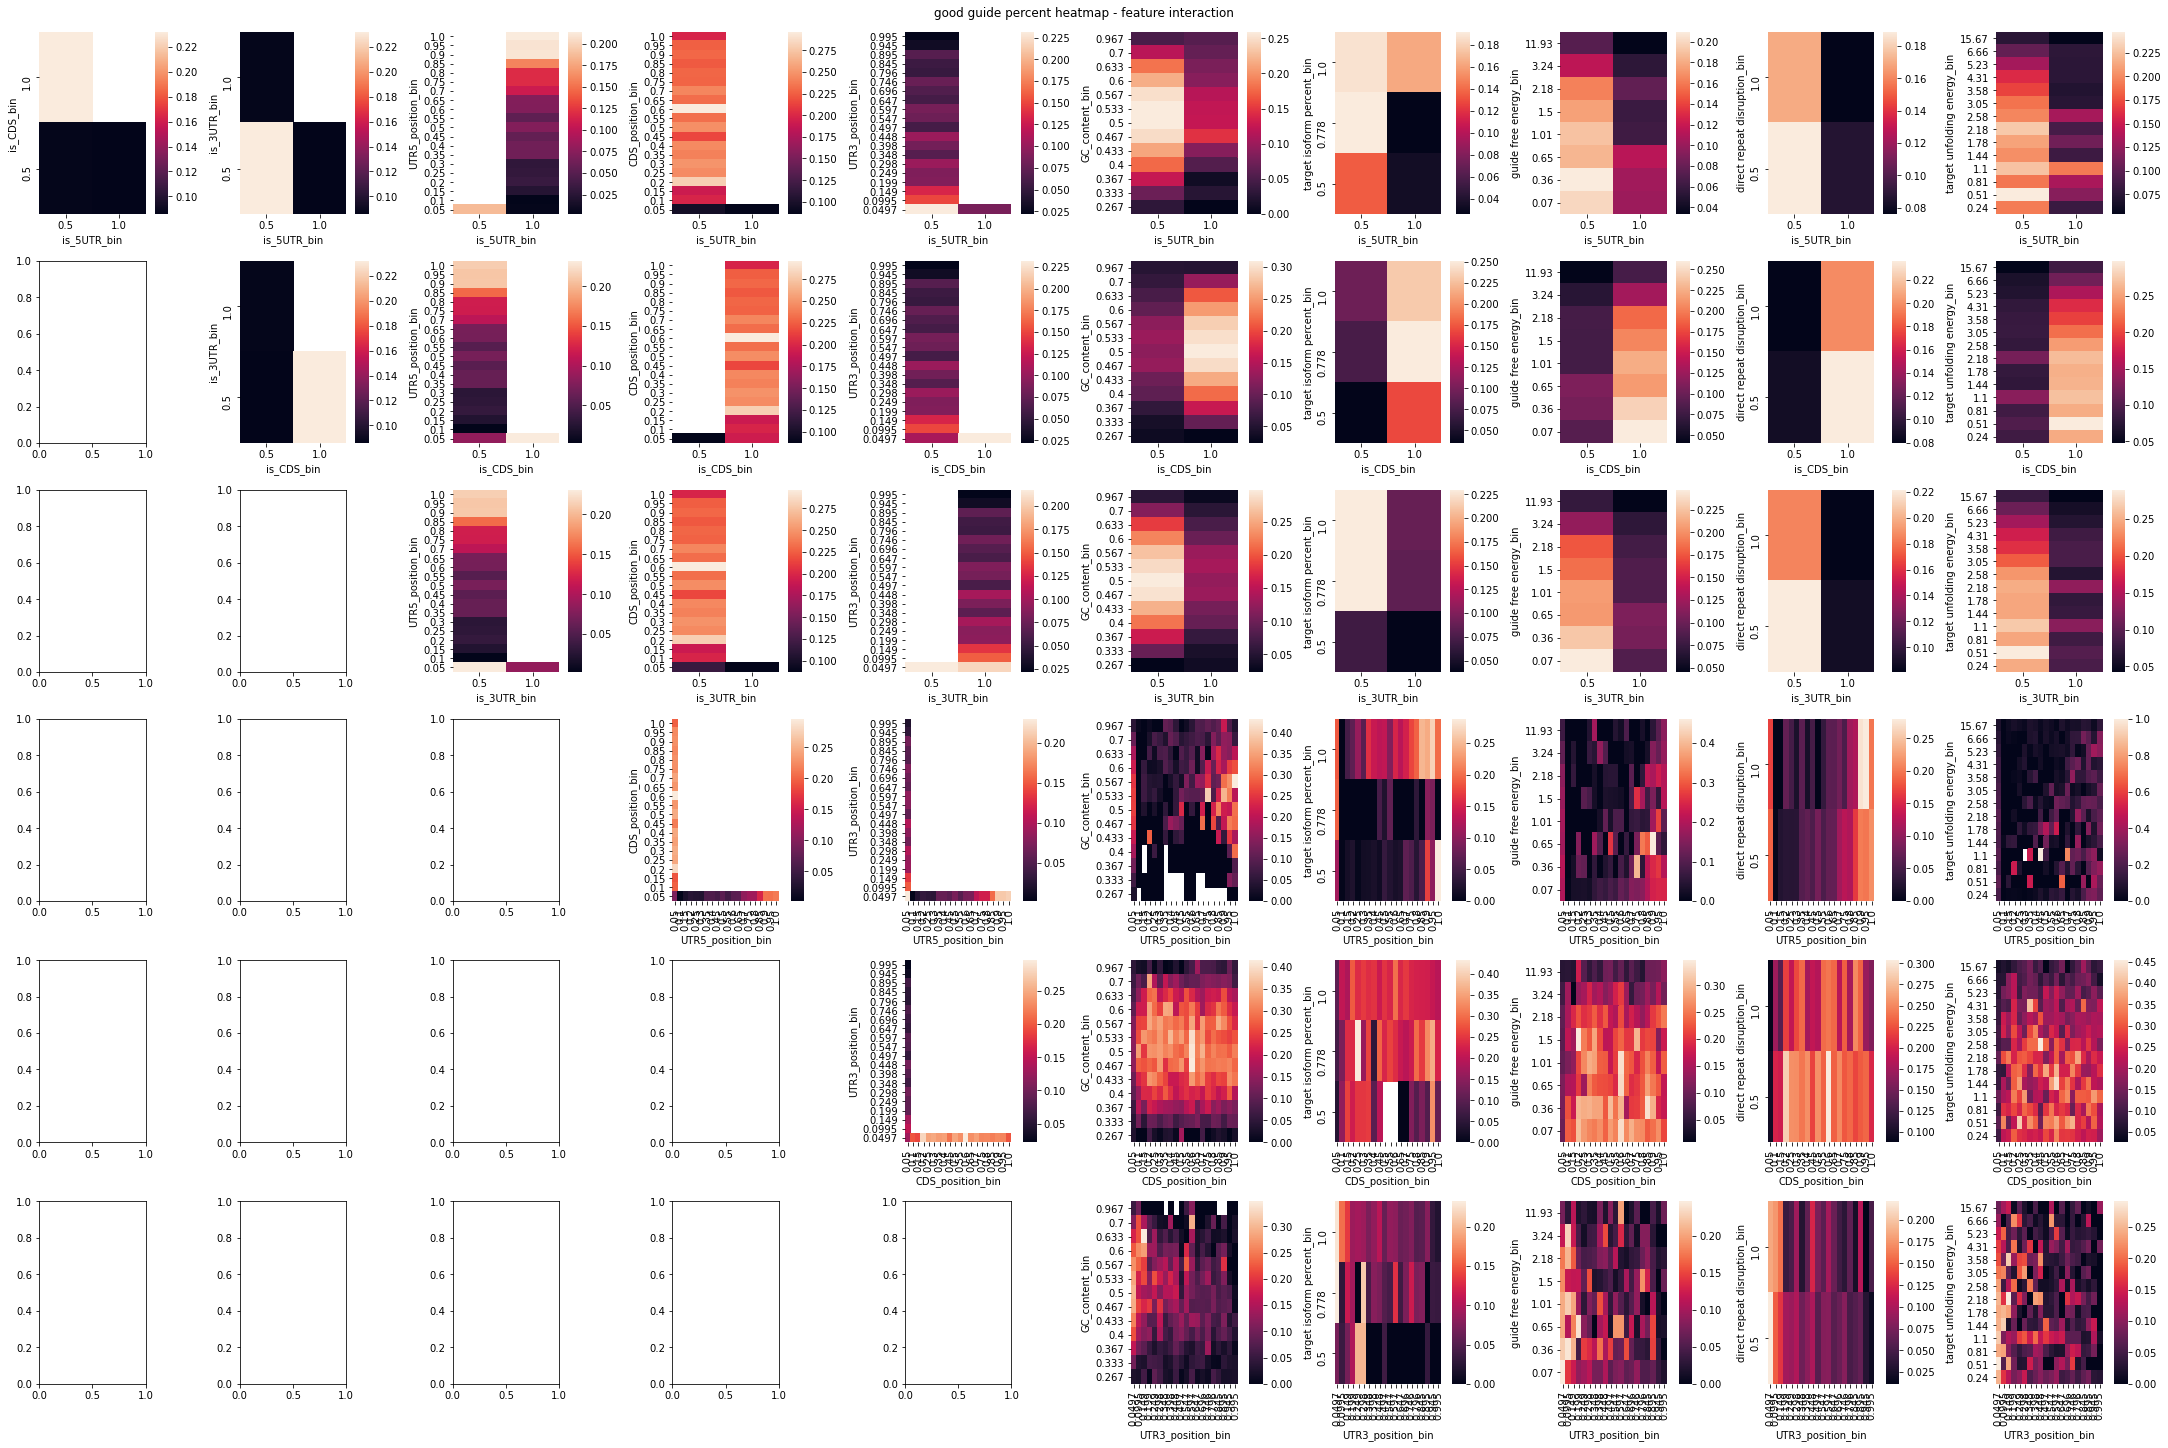

In [21]:
plt.clf()
fig, ax = plt.subplots(6,len(features)-4,figsize=(30,20),constrained_layout=True)
fig.suptitle('good guide percent heatmap - feature interaction')
for i in range(6): # pos flag and floats
    for j in range(i+1,(len(features)-3)):
        fx = feature_name[i] + '_bin'
        fy = feature_name[j] + '_bin'
        means = dataframe.join(cuts).groupby([fx,fy])['binary_relative_ratio_075f'].mean()
        means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
        # Reverse the order of the rows as the heatmap will print from top to bottom.
        means = means.iloc[::-1]
        #use the right bin value as label
        sns.heatmap(means,xticklabels = means.columns.map(lambda x : x.right),
                            yticklabels = means.index.map(lambda x : x.right),ax=ax[i,j-1])
        
plt.savefig('../a_figures/feature_interaction2_pos.svg')

<Figure size 432x288 with 0 Axes>

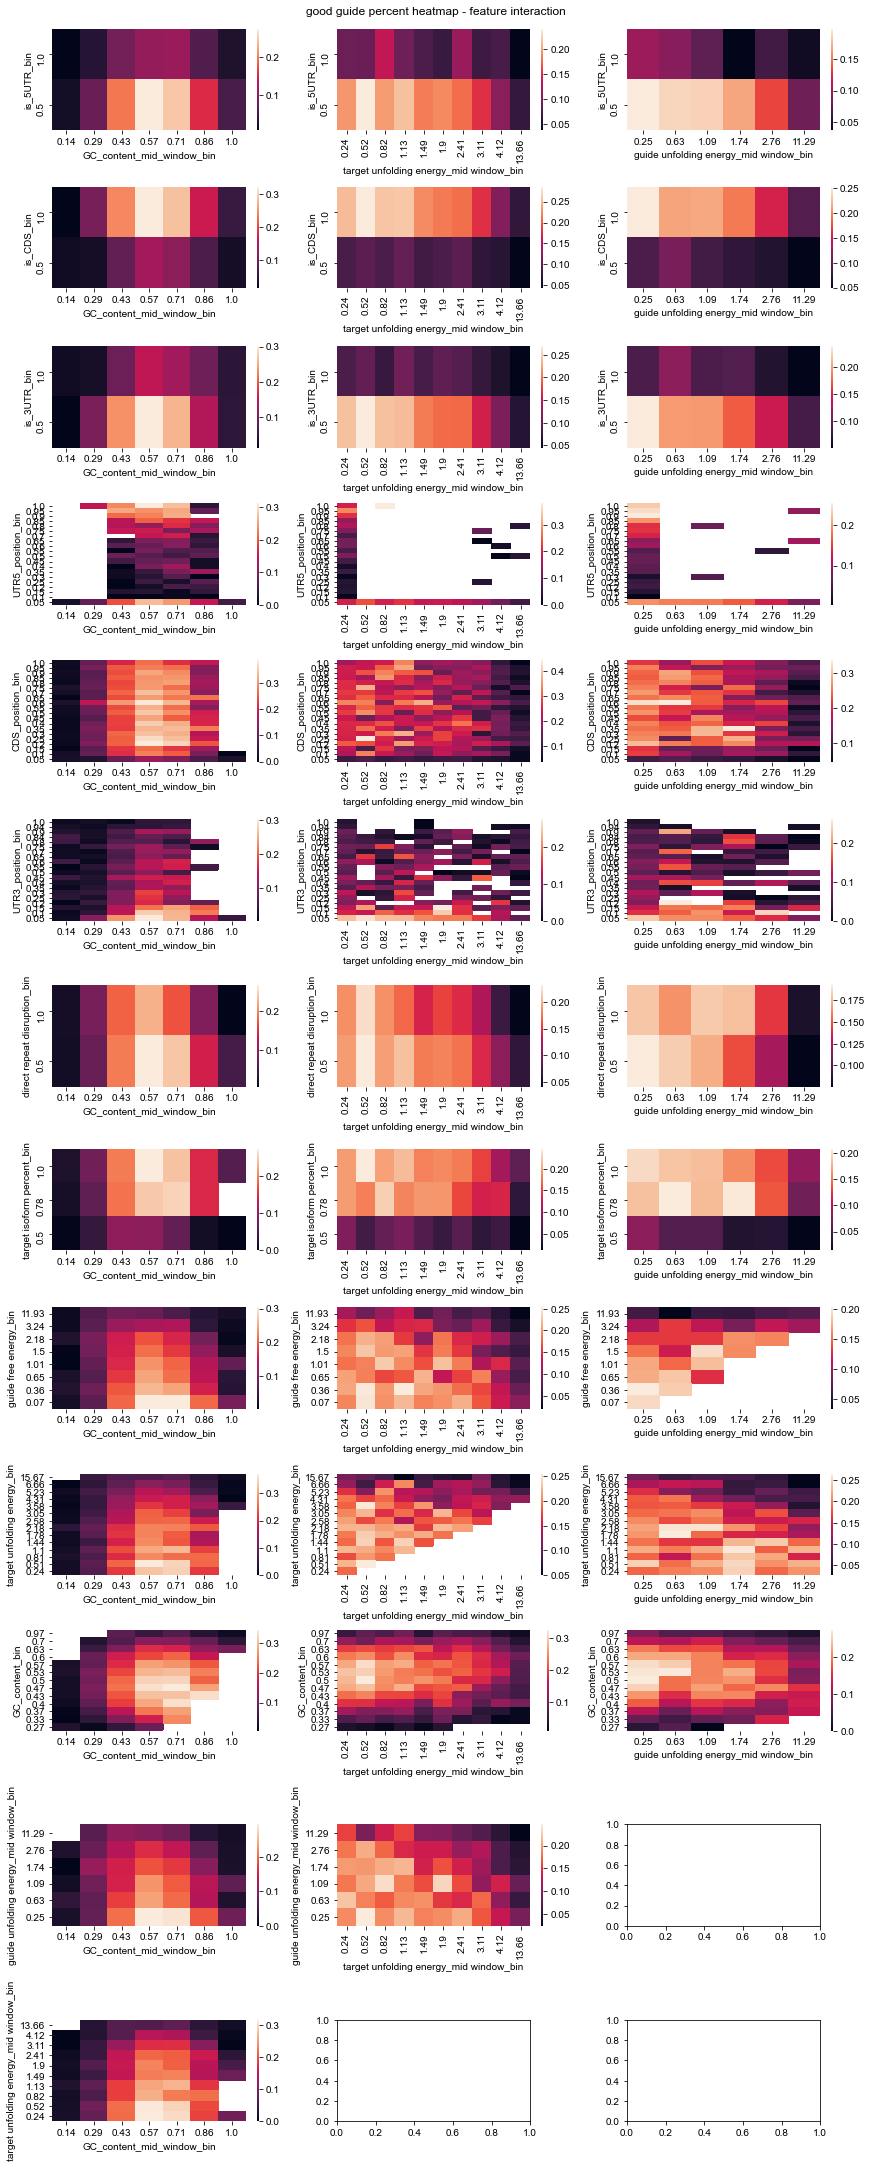

In [8]:
# mid window features
features = ['is_5UTR','is_CDS','is_3UTR','UTR5_position','CDS_position','UTR3_position','linearfold_dr_flag','refseq_target_transcript_percent','linearfold_vals','target unfold energy','GC_content',
            'linearfold_vals_7win','target unfold energy_7win','GC_content_mid']
feature_name = ['is_5UTR','is_CDS','is_3UTR','UTR5_position','CDS_position','UTR3_position','direct repeat disruption','target isoform percent','guide free energy','target unfolding energy','GC_content',
                'guide unfolding energy_mid window','target unfolding energy_mid window','GC_content_mid_window']

plt.clf()
plt.rcParams['svg.fonttype'] = 'none'
#plt.rcParams['text.usetex'] = True
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

fig, ax = plt.subplots(13,3,figsize=(12,30),constrained_layout=True)
fig.suptitle('good guide percent heatmap - feature interaction')
#for i in range(8,len(features)): # non-pos features
mid_feature_list = ['GC_content_mid_window','guide unfolding energy_mid window','target unfolding energy_mid window']
for i in range(len(features)-1,len(features)-4,-1): 
    for j in range(i):
        fx = feature_name[i] + '_bin'
        fy = feature_name[j] + '_bin'
        grouped = dataframe.join(cuts).groupby([fx,fy])
        size_g = grouped.size()
        size_g = size_g.unstack(level = 0) # Use level 0 to put 0Bin as columns.
        size_g = size_g.mask(size_g <= 50)
        size_g = size_g.mask(size_g > 50, 1)
        #grouped.filter(lambda x: len(x) > 50)
        means = grouped['binary_relative_ratio_075f'].mean()
        means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
        # Reverse the order of the rows as the heatmap will print from top to bottom.
        means = means.multiply(size_g)
        means = means.iloc[::-1]
        #use the right bin value as label
        sns.heatmap(means,xticklabels = means.columns.map(lambda x : round(x.right,2)),
                            yticklabels = means.index.map(lambda x : round(x.right,2)),ax=ax[j,len(features)-1-i])

plt.savefig('../a_figures/feature_interaction_midwindow.svg')

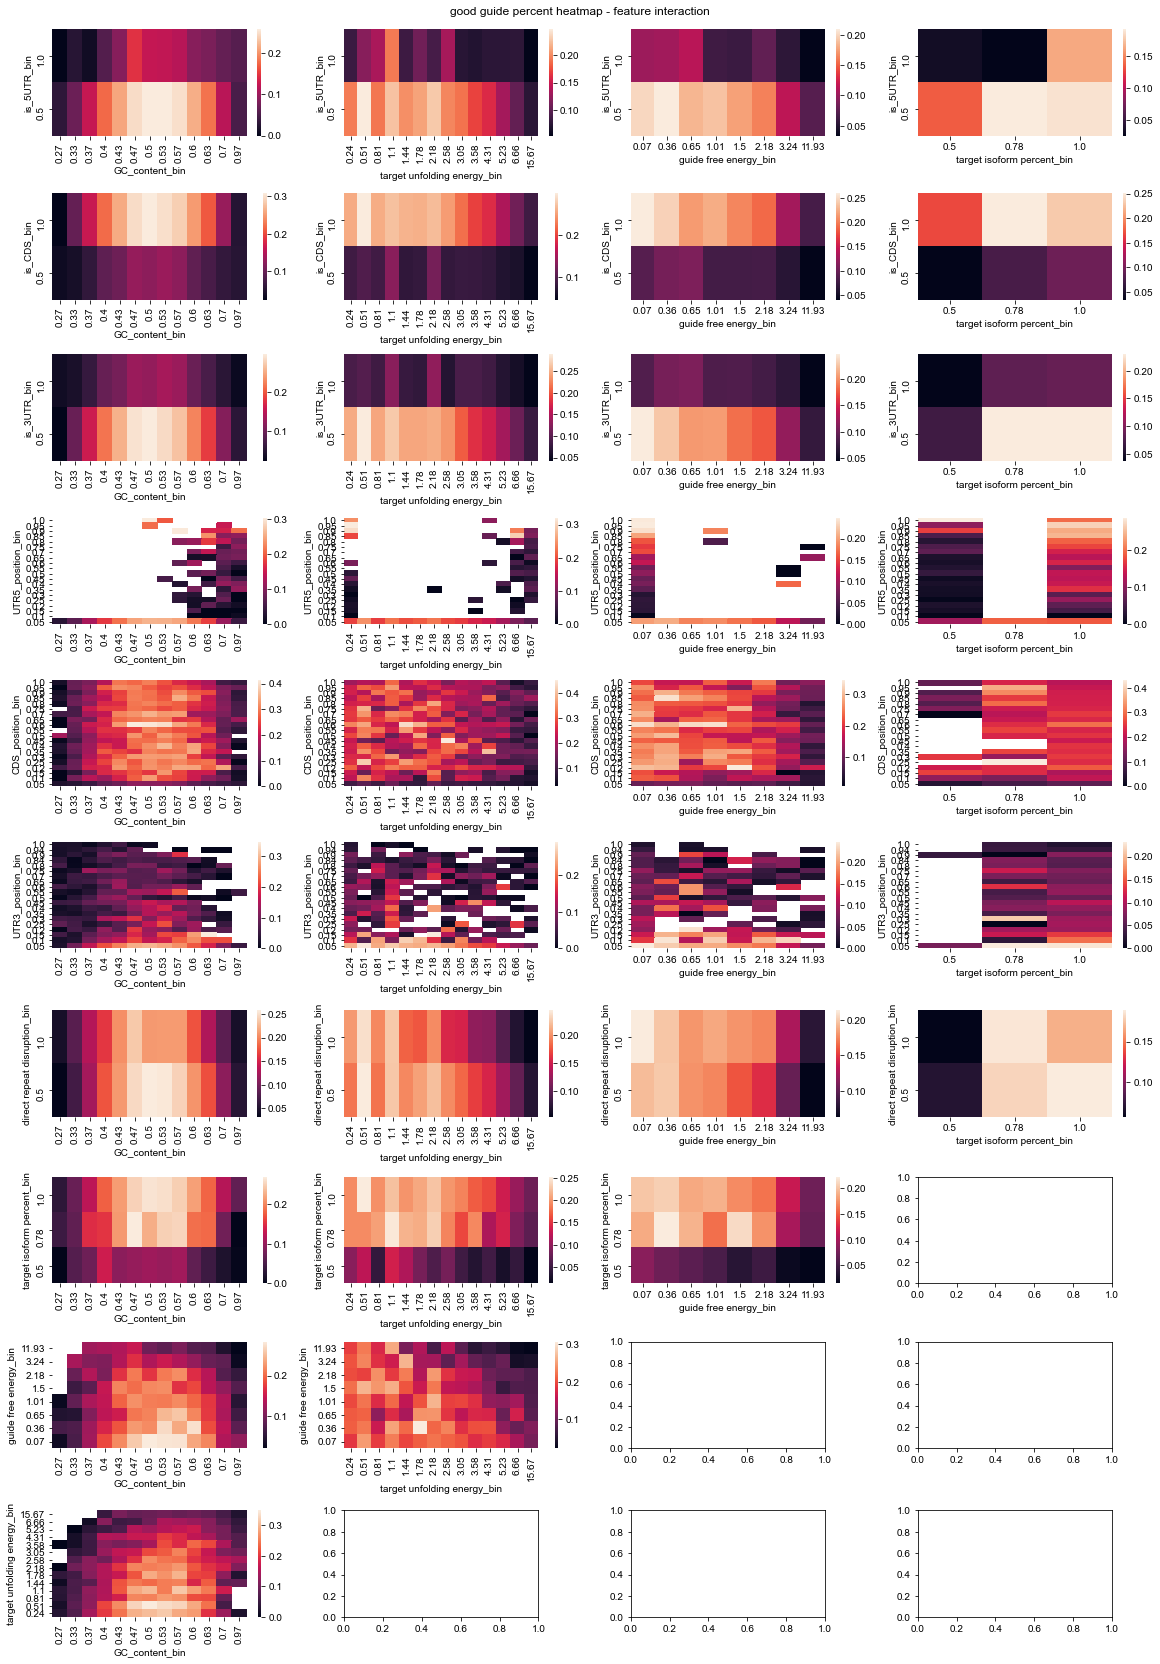

In [9]:
fig, ax = plt.subplots(10,4,figsize=(16,23),constrained_layout=True)
fig.suptitle('good guide percent heatmap - feature interaction')

for i in range(len(features)-4,len(features)-8,-1):  # whole guide non-pos features
    for j in range(i):
        fx = feature_name[i] + '_bin'
        fy = feature_name[j] + '_bin'
        grouped = dataframe.join(cuts).groupby([fx,fy])
        size_g = grouped.size()
        size_g = size_g.unstack(level = 0) # Use level 0 to put 0Bin as columns.
        size_g = size_g.mask(size_g <= 50)
        size_g = size_g.mask(size_g > 50, 1)
        #grouped.filter(lambda x: len(x) > 50)
        means = grouped['binary_relative_ratio_075f'].mean()
        means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
        # Reverse the order of the rows as the heatmap will print from top to bottom.
        means = means.multiply(size_g)
        means = means.iloc[::-1]
        #use the right bin value as label
        sns.heatmap(means,xticklabels = means.columns.map(lambda x : round(x.right,2)),
                            yticklabels = means.index.map(lambda x : round(x.right,2)),ax=ax[j,len(features)-4-i])

plt.savefig('../a_figures/feature_interaction_wholeguide.svg')

In [32]:
df_all = dataframe.join(cuts)
df_sel = df_all[(df_all['GC_content_mid_window_bin']==pd.Interval(0.429, 0.571, closed='right'))&
              (df_all['CDS_position_bin']== pd.Interval(0.15, 0.2, closed='right'))]
print(len(df_sel))
print(df_sel['binary_relative_ratio_075f'].mean())
gene_num = df_sel.groupby('gene').size()
#df_sel.groupby('gene')['binary_relative_ratio_075f'].sum()
df_sel.groupby('gene')['binary_relative_ratio_075f'].agg(['count','mean', 'sum'])

1136
0.3873239436619718


,count,mean,sum
gene,,,
AQR,53,0.528302,28.0
ARCN1,25,0.160000,4.0
CDC5L,20,0.100000,2.0
COPS6,14,0.357143,5.0
COPZ1,12,0.166667,2.0
CSE1L,36,0.666667,24.0
DDX51,4,0.000000,0.0
EEF2,38,0.473684,18.0
EIF4A3,23,0.434783,10.0


In [31]:
df_sel = df_all[(df_all['GC_content_mid_window_bin']==pd.Interval(0.429, 0.571, closed='right'))&
              (df_all['CDS_position_bin']== pd.Interval(0.55, 0.6, closed='right'))]
print(len(df_sel))
print(df_sel['binary_relative_ratio_075f'].mean())
#df_sel.groupby('gene')['binary_relative_ratio_075f'].sum()
df_sel.groupby('gene')['binary_relative_ratio_075f'].agg(['count','mean', 'sum']) #guide number, good guide percent, good guide number
#agg({   'col3': ['mean', 'count'],   'col4': ['median', 'min', 'count']})

1167
0.3838903170522708


,count,mean,sum
gene,,,
AQR,61,0.295082,18.0
ARCN1,17,0.764706,13.0
CDC5L,37,0.378378,14.0
COPS6,22,0.545455,12.0
COPZ1,7,0.000000,0.0
CSE1L,21,0.190476,4.0
DDX51,15,0.600000,9.0
EEF2,45,0.155556,7.0
EIF4A3,21,0.428571,9.0


In [22]:
#4,12
df_all['CDS_position_bin'].values

[(-0.001, 0.05], (-0.001, 0.05], (-0.001, 0.05], (-0.001, 0.05], (-0.001, 0.05], ..., (0.7, 0.75], (0.6, 0.65], (-0.001, 0.05], (0.5, 0.55], (0.15, 0.2]]
Length: 119399
Categories (20, interval[float64]): [(-0.001, 0.05] < (0.05, 0.1] < (0.1, 0.15] < (0.15, 0.2] ... (0.8, 0.85] < (0.85, 0.9] < (0.9, 0.95] < (0.95, 1.0]]

In [15]:
pd.Interval(-0.001, 0.143, closed='right')

Interval(-0.001, 0.143, closed='right')

## CD genes

In [11]:
dataset_filtered_csv_path = 'validation_genes/cdscreen_filtered_t1_new_features_ratios.csv'
#dataset
dataframe = pd.read_csv(dataset_filtered_csv_path)
num_examples = len(dataframe['guide'].values)

#GC content
gc_content = []
for guide in dataframe['guide'].values:
    gc_num = (guide.upper()).count('G') + (guide.upper()).count('C')
    gc_content.append(gc_num/30)
dataframe['GC_content']=gc_content


#GC content in the window 17-23
gc_content_win = []
for guide in dataframe['guide'].values:
    gc_num = (guide[16:23].upper()).count('G') + (guide[16:23].upper()).count('C')
    gc_content_win.append(gc_num/7)
    
dataframe['GC_content_mid'] = gc_content_win

#divide guides to 10 bins
bin_labels = [i for i in range(1,11)]
dataframe['bins'] = pd.qcut(dataframe['t1_bin1_to_sum_bin14_rank_withr3'],
                              q=10,
                              labels=bin_labels)

#outputs_te = tedf['t1_bin1_to_sum_bin14_rank_withr3'].values if args.regression else tedf['t1_binary_relative_ratio_withrep3'].values

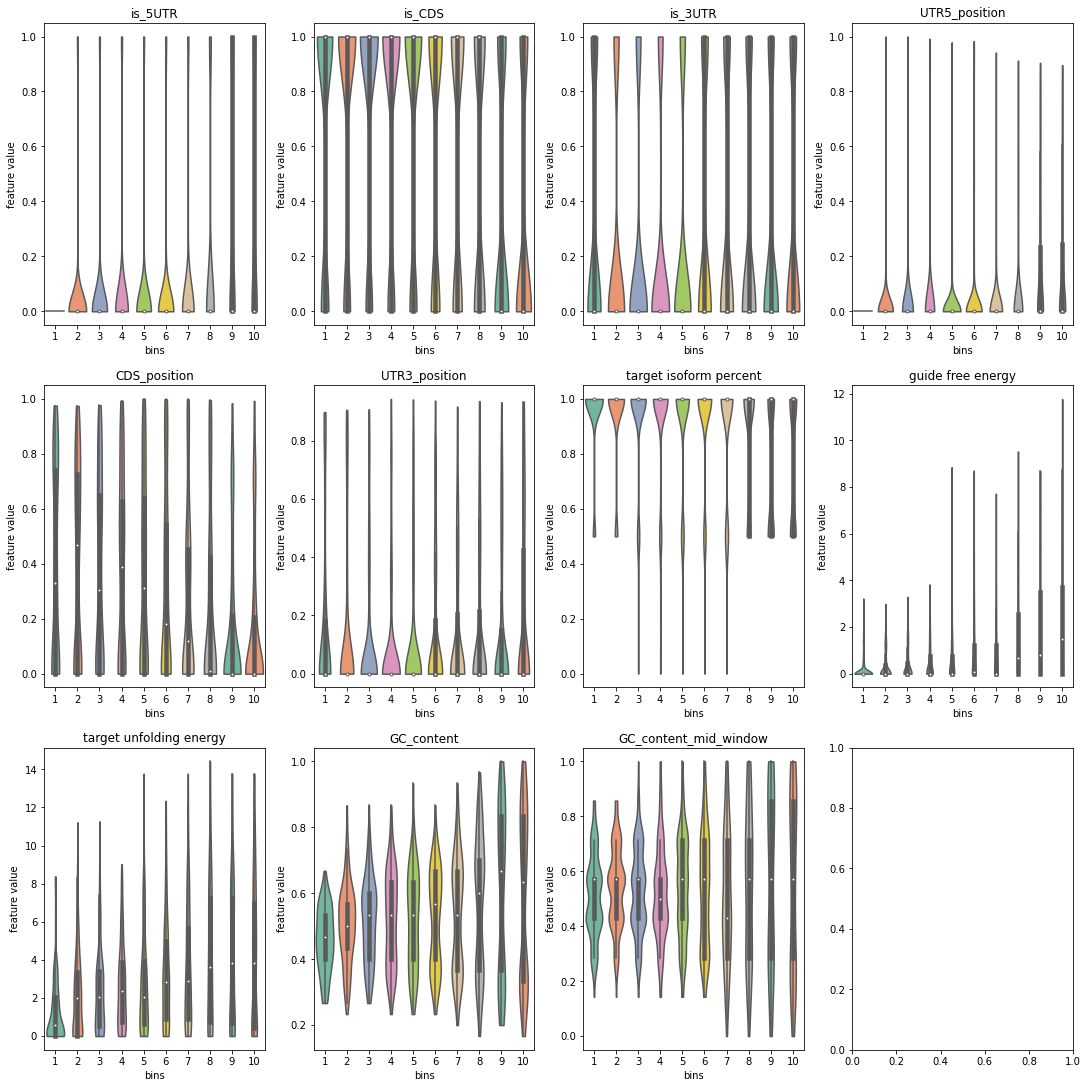

In [13]:
features = ['is_5UTR','is_CDS','is_3UTR','UTR5_position','CDS_position','UTR3_position','refseq_target_transcript_percent','linf_contrafold_val','target_flank_ddg','GC_content','GC_content_mid']
feature_name = ['is_5UTR','is_CDS','is_3UTR','UTR5_position','CDS_position','UTR3_position','target isoform percent','guide free energy','target unfolding energy','GC_content','GC_content_mid_window']


fig, ax = plt.subplots(3,4,figsize=(15,15),constrained_layout=True)
for i in range(len(features)):
    px = int((i-i%4)/4)
    py = int(i%4)
    sns.violinplot(x="bins", y=features[i],
                   data=dataframe, cut=0,palette="Set2",ax=ax[px,py])
    ax[px,py].set_title(feature_name[i])
    ax[px,py].set_xlabel('bins')
    ax[px,py].set_ylabel('feature value')
    
#plt.savefig('a_figures/cd_feature_histograms.svg', format="svg")

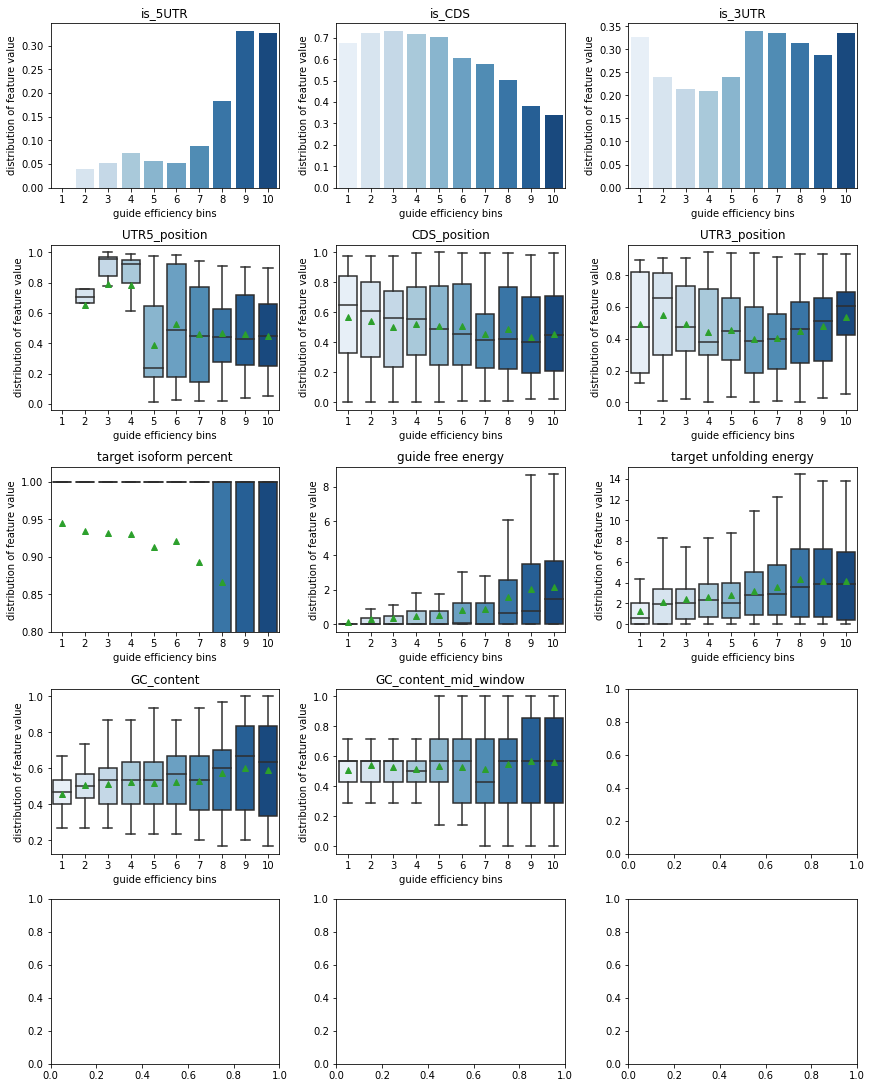

In [14]:
#bar plot and box plot

#fig, ax = plt.subplots(4,3,figsize=(9,12),constrained_layout=True)
fig, ax = plt.subplots(5,3,figsize=(12,15),constrained_layout=True)
for i in range(len(features)):
    px = int((i-i%3)/3)
    py = int(i%3)
    if features[i] in ['is_5UTR','is_CDS','is_3UTR']: #flag features, bar plot
        sns.barplot(x="bins", y=features[i], data=dataframe,ci=None,
                  palette="Blues",ax=ax[px,py])
    elif features[i] in ['UTR5_position','CDS_position','UTR3_position']: #filter 0
        df_nonzero = dataframe[dataframe[features[i]]!=0]
        #df_nonzero.boxplot(column=features[i], by='bins', ax=ax[px,py], grid=False,showfliers=False)
        #sns.boxplot(x="bins", y=features[i], data=df_nonzero,ax=ax[px,py],showfliers=False,palette="ch:s=.25,rot=-.25",meanline=True)
        sns.boxplot(x="bins", y=features[i], data=df_nonzero,ax=ax[px,py],showfliers=False,palette="Blues",showmeans=True)
        #sns.color_palette("light:#5A9", as_cmap=True)
        #sns.boxplot(x="bins", y=features[i], data=df_nonzero,ax=ax[px,py],showfliers=False,**PROPS)
    else:
        #dataframe.boxplot(column=features[i], by='bins', ax=ax[px,py], grid=False,showfliers=False) 
        #sns.boxplot(x="bins", y=features[i], data=dataframe,ax=ax[px,py],showfliers=False,palette="ch:s=.25,rot=-.25",meanline=True)
        sns.boxplot(x="bins", y=features[i], data=dataframe,ax=ax[px,py],showfliers=False,palette="Blues",showmeans=True)
        #sns.color_palette("light:#5A9", as_cmap=True)
        #sns.boxplot(x="bins", y=features[i], data=dataframe,ax=ax[px,py],showfliers=False,**PROPS)
    ax[px,py].set_title(feature_name[i])
    if feature_name[i] == 'target isoform percent':
        ax[px,py].set_ylim(0.8,1.02)
    ax[px,py].set_xlabel('guide efficiency bins')
    ax[px,py].set_ylabel('distribution of feature value')

<ipython-input-15-11f632d4a51e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonzero['feature_bins'] = pd.cut(df_nonzero[features[i]],
<ipython-input-15-11f632d4a51e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonzero['feature_bins'] = pd.cut(df_nonzero[features[i]],
<ipython-input-15-11f632d4a51e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

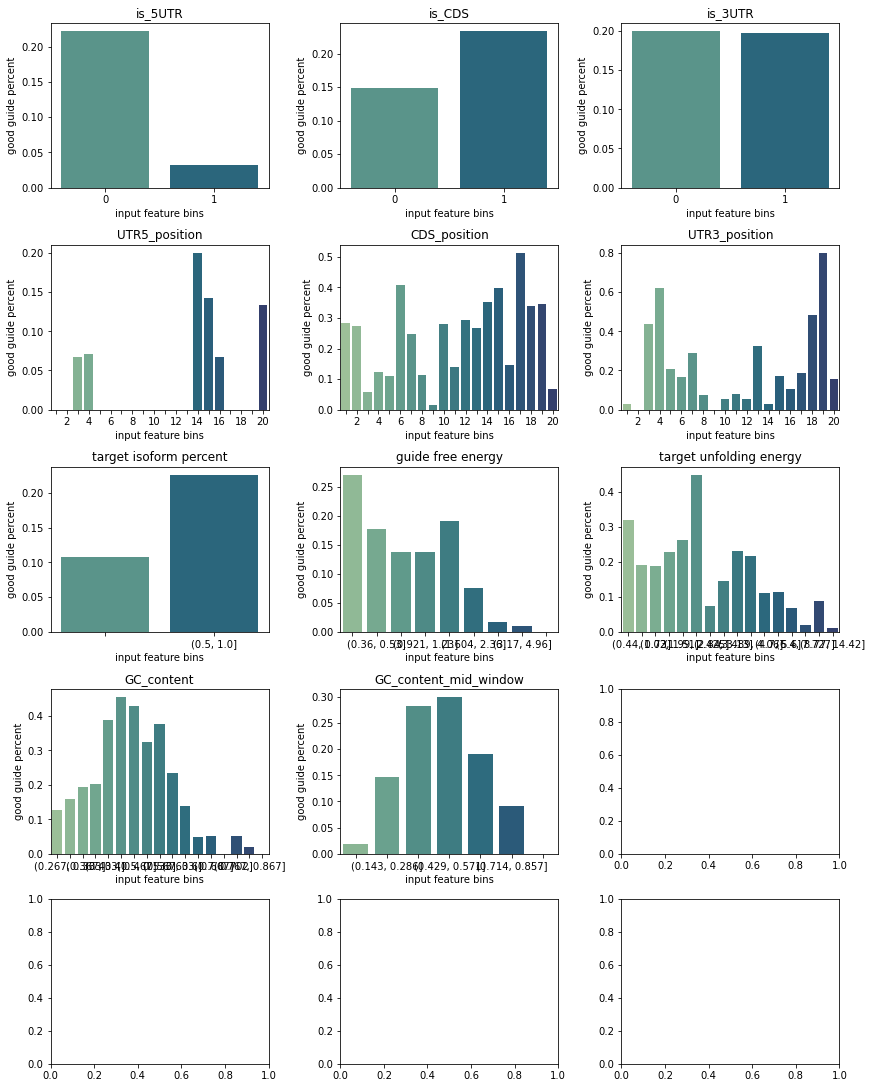

In [15]:
#good guides' percent in feature bins

#fig, ax = plt.subplots(4,3,figsize=(8,12),constrained_layout=True)
fig, ax = plt.subplots(5,3,figsize=(12,15),constrained_layout=True)
for i in range(len(features)):
    px = int((i-i%3)/3)
    py = int(i%3)
    if features[i] in ['is_5UTR','is_CDS','is_3UTR']:
        sns.barplot(x=features[i], y='t1_binary_relative_ratio_withrep3', data=dataframe,ci=None,
                  palette="crest",ax=ax[px,py])
        #fm = dataframe.groupby(features[i])['binary_relative_ratio_075f'].agg('mean')
        #fm.plot(ax=ax[px,py])
    elif features[i] in ['UTR5_position','CDS_position','UTR3_position']: #filter 0
        df_nonzero = dataframe[dataframe[features[i]]!=0]
        bin_labels = [i for i in range(1,21)]
        df_nonzero['feature_bins'] = pd.cut(df_nonzero[features[i]],
                                  bins=20,
                                  labels=bin_labels)
        sns.barplot(x='feature_bins', y='t1_binary_relative_ratio_withrep3', data=df_nonzero,ci=None,
                  palette="crest",ax=ax[px,py])
        for label in ax[px,py].xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
    else:
        #divide to 20 bins based on feature input
        bin_labels = [i for i in range(1,21)]
        #dataframe['feature_bins'] = pd.cut(dataframe[features[i]],
        #                          bins=20,labels=bin_labels)
        dataframe['feature_bins'] = pd.qcut(dataframe[features[i]],
                              q=20,
                              duplicates='drop')
        sns.barplot(x='feature_bins', y='t1_binary_relative_ratio_withrep3', data=dataframe,ci=None,
                  palette="crest",ax=ax[px,py])
        for label in ax[px,py].xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
        #fm = dataframe.groupby('feature_bins')['binary_relative_ratio_075f'].agg('mean')
        #fm.plot(ax=ax[px,py])
    
    #df_class[features[i]].hist(grid=False, alpha = 0.4,bins=50,density = True,ax=ax[px,py],legend = True)
    ax[px,py].set_title(feature_name[i])
    ax[px,py].set_xlabel('input feature bins')
    ax[px,py].set_ylabel('good guide percent')
    #ax[px,py].legend()
